## Аналитика в Яндекс.Афише

Наша задача - оптимизировать маркетинговые затраты.

### Шаг 1. Загрузка данных и предобработка.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('datasets/visits_log.csv')
orders = pd.read_csv('datasets/orders_log.csv')
costs = pd.read_csv('datasets/costs.csv')

In [3]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid'] # переименуем столбцы для удобства
orders.columns = ['buy_ts', 'revenue', 'uid']
visits['start_ts'] = pd.to_datetime(visits['start_ts']) # приведем даты к нужному формату
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

#### Вывод по шагу 1.

Данные загружены, форматы данных исправлены.

### Шаг 2.1. Анализ посещений сайта.

In [4]:
visits['year'] = visits['start_ts'].dt.year # выделим год, месяц, неделю и день сессии
visits['month'] = visits['start_ts'].dt.month
visits['week'] = visits['start_ts'].dt.week
visits['date'] = visits['start_ts'].dt.date
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds # определим продолжительность сессий

In [5]:
# посчитаем метрики количества посетителей в месяц, неделю и день
mau = visits.groupby(['year', 'month']).agg({'uid':'nunique'}).mean()
wau = visits.groupby(['year', 'week']).agg({'uid':'nunique'}).mean()
dau = visits.groupby(['date']).agg({'uid':'nunique'}).mean()
print('Среднее количество уникальных пользователей в месяц:', int(mau))
print('Среднее количество уникальных пользователей в неделю:', int(wau))
print('Среднее количество уникальных пользователей в день:', int(dau))

Среднее количество уникальных пользователей в месяц: 23228
Среднее количество уникальных пользователей в неделю: 5716
Среднее количество уникальных пользователей в день: 907


Среднее количество сессий в день: 987


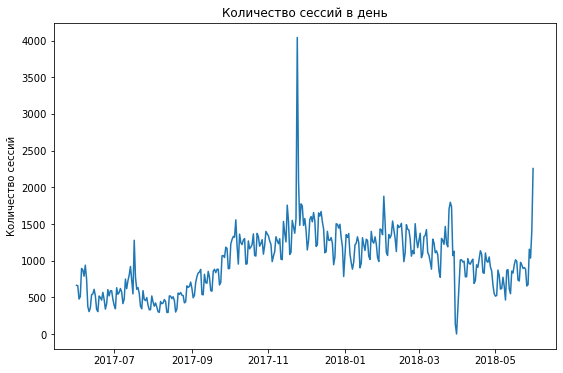

In [6]:
# определим среднее количество сессий в день
n_sess = visits.groupby(['date']).agg({'start_ts':'count'}).mean()
print('Среднее количество сессий в день:', int(n_sess))

session_by_day = visits.groupby(['date']).agg({'start_ts':'count'})

fig = plt.figure(figsize=(9, 6))
plt.plot(session_by_day.index, session_by_day['start_ts'])
plt.ylabel('Количество сессий')
plt.title('Количество сессий в день')
plt.show()

In [7]:
# посчитаем медианную продолжительность сессии
desktop_duration = visits[visits['device'] == 'desktop']['duration'].median()
mobile_duration = visits[visits['device'] == 'touch']['duration'].median()
print('Медианная продолжительность десктопных сессий:', desktop_duration, 'сек.')
print('Медианная продолжительность мобильных сессий:', mobile_duration, 'сек.')

Медианная продолжительность десктопных сессий: 360.0 сек.
Медианная продолжительность мобильных сессий: 180.0 сек.


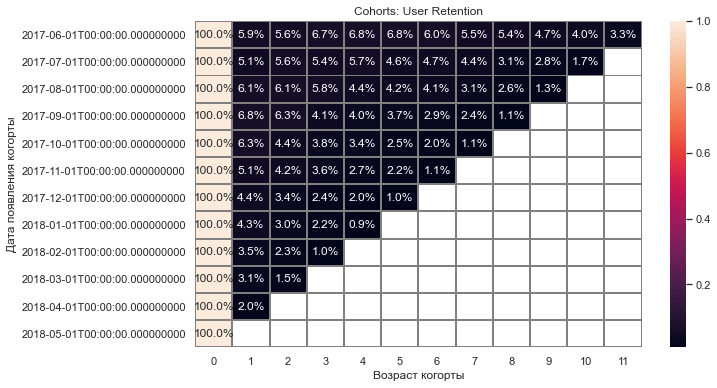

In [8]:
# для того, чтобы определить, как часто посетители возвращаются на сайт, подсчитаем Retention Rate и Churn Rate по когортам

first_visits = visits.groupby('uid').agg({'date':'min'}).reset_index()
first_visits.columns = ['uid', 'first_visit_date']
visits = pd.merge(visits, first_visits, on='uid')
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['cohort_lifetime'] = visits['date'] - visits['first_visit_date']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype(int)
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(10, 6))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
ax.set(xlabel='Возраст когорты', ylabel='Дата появления когорты')
plt.show()
# для расчета времени жизни когорты использован метод .astype(int), как в тренажере

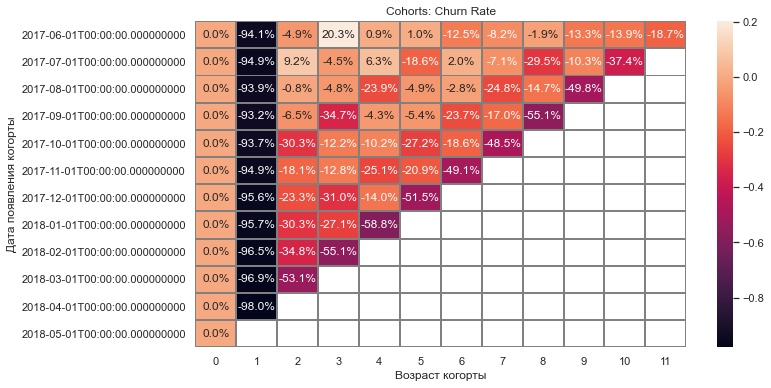

In [9]:
# для того, чтобы определить, как часто посетители возвращаются на сайт, подсчитаем Retention Rate и Churn Rate по когортам
cohorts['churn_rate'] = cohorts.groupby(['first_visit_month'])['uid'].pct_change()
churn_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='churn_rate',aggfunc='sum')
sns.set(style='white')
plt.figure(figsize=(11, 6))
plt.title('Cohorts: Churn Rate')
ax = sns.heatmap(churn_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
ax.set(xlabel='Возраст когорты', ylabel='Дата появления когорты')
plt.show()

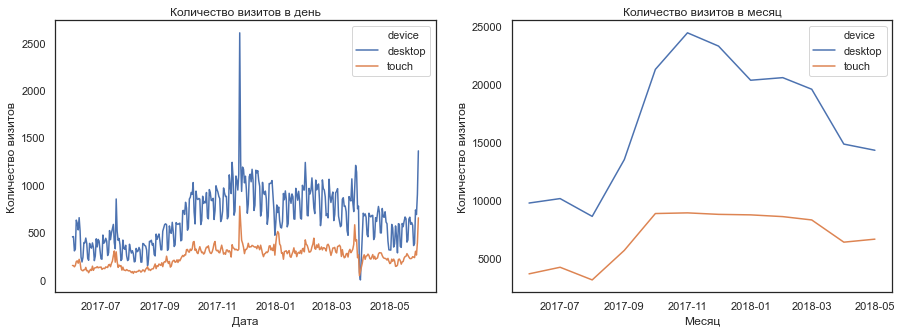

In [10]:
# в дополнение на примере DAU и MAU изучим, как распределяются наши метрики по девайсам (десктоп/мобильная версия)
visits_by_day = visits.groupby(['date', 'device']).agg({'uid':'nunique'}).reset_index()
visits_by_month = visits.groupby(['visit_month', 'device']).agg({'uid':'nunique'}).reset_index()

fig = plt.figure(figsize=(15, 5))
area = fig.add_subplot(1, 2, 1)
sns.lineplot(x=visits_by_day['date'], y=visits_by_day['uid'], hue=visits_by_day['device'])
plt.xlabel('Дата')
plt.ylabel('Количество визитов')
plt.title('Количество визитов в день')
area = fig.add_subplot(1, 2, 2)
sns.lineplot(x=visits_by_month['visit_month'], y=visits_by_month['uid'], hue=visits_by_month['device'])
plt.xlabel('Месяц')
plt.ylabel('Количество визитов')
plt.title('Количество визитов в месяц')
plt.show()

#### Выводы по шагу 2.1.

- Как мы видим по таблицам Retention Rate и Churn Rate, важная проблема - удержание пользователей: лишь несколько процентов из тех, кто сделал покупку, возвращается в следующий месяц. 
- В то же время успешная маркетинговая работа в декабре 2017 в несколько раз увеличила количество сессий в день.
- Можно заметить, что доля десктопного трафика заметно превышает долю визитов с мобильных устройств
- В среднем покупатели проводят на сайте 3-6 минут

### Шаг 2.2. Анализ продаж.

Время между первым визитом и первой покупкой, в минутах (медиана): 16.0
Время между первым визитом и первой покупкой, в минутах (мода): 0    1.0
dtype: float64


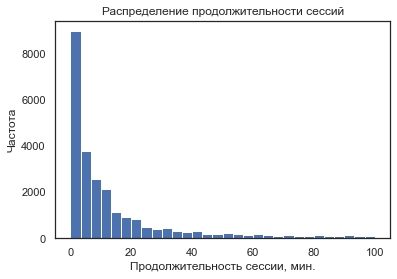

In [11]:
#подсчитаем, через сколько времени после первого визита люди делают первую покупку
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_session = visits.groupby('uid').agg({'start_ts':'min'})
first_order = orders.groupby('uid').agg({'buy_ts':'min'})
time_diff = pd.merge(first_session, first_order, on='uid')
time_diff['time_diff'] = (time_diff['buy_ts'] - time_diff['start_ts']).dt.seconds / 60
print('Время между первым визитом и первой покупкой, в минутах (медиана):', time_diff['time_diff'].median())
print('Время между первым визитом и первой покупкой, в минутах (мода):', time_diff['time_diff'].mode())
#построим гистограмму распределения времени сессий до 100 минут
plt.hist(time_diff['time_diff'], bins=30, range=(0, 100))
plt.xlabel('Продолжительность сессии, мин.')
plt.ylabel('Частота')
plt.title('Распределение продолжительности сессий')
plt.show()

In [12]:
# подсчитаем LTV по когортам
first_orders = orders.groupby('uid').agg({'order_month':'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
orders = pd.merge(orders, first_orders, on='uid')
cohorts2 = orders.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
report = pd.merge(cohort_sizes, cohorts2, on='first_order_month')
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
result = report.pivot_table(index='first_order_month', columns='age', values='ltv', aggfunc='mean')
result.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.72,5.21,5.65,6.6,7.62,8.36,9.31,9.89,10.45,11.05,11.62,11.88
2017-07-01,6.01,6.35,6.97,7.33,7.5,7.66,7.78,7.92,8.08,8.23,8.39,
2017-08-01,5.28,5.75,6.21,6.6,7.09,7.38,7.59,7.99,8.28,8.47,,
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31,13.01,13.25,13.44,,,
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16,6.24,6.36,,,,
2017-11-01,5.15,5.55,5.75,6.08,6.23,6.28,6.4,,,,,
2017-12-01,4.74,5,5.92,6.99,7.3,7.64,,,,,,
2018-01-01,4.14,4.43,4.73,4.88,4.94,,,,,,,
2018-02-01,4.16,4.44,4.51,4.59,,,,,,,,


In [13]:
# подсчитаем количество покупок за месяц по когортам
cohorts3 = orders.groupby(['first_order_month', 'order_month']).agg({'buy_ts':'count'}).reset_index()
cohorts3.columns = ['first_order_month', 'order_month', 'number_of_orders']
cohorts3['age'] = (cohorts3['order_month'] - cohorts3['first_order_month']) / np.timedelta64(1, 'M')
cohorts3['age'] = cohorts3['age'].round().astype('int')
result2 = cohorts3.pivot_table(index='first_order_month', columns='age', values='number_of_orders', aggfunc='sum').fillna('')
result2

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,2354.0,177,174,226,292,218,276,174,212,153,96,86
2017-07-01,2186.0,100,120,104,72,82,61,50,58,24,53,
2017-08-01,1533.0,108,100,81,85,62,49,78,46,46,,
2017-09-01,2933.0,219,161,164,67,109,108,56,61,,,
2017-10-01,4964.0,314,162,122,129,103,86,125,,,,
2017-11-01,4813.0,397,182,211,136,59,102,,,,,
2017-12-01,5052.0,270,202,179,86,105,,,,,,
2018-01-01,3783.0,224,159,64,78,,,,,,,
2018-02-01,4095.0,222,83,70,,,,,,,,


In [14]:
# подсчитаем средний чек - разделим весь объем выручки за месяц на количество совершенных покупок и сгруппируем по когортам
result3 = pd.merge(cohorts2, cohorts3, on=['first_order_month', 'order_month'])
result3['avg_order_value'] = result3['revenue'] / result3['number_of_orders']
result3.head()
result3_pivot = result3.pivot_table(index='first_order_month', columns='age', values='avg_order_value').round(2).fillna('')
result3_pivot

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.06,5.55,5.09,8.55,7.08,6.83,6.97,6.76,5.28,8.01,12.04,6.04
2017-07-01,5.29,6.45,9.99,6.64,4.72,3.66,3.79,5.45,5.35,11.79,5.65,
2017-08-01,4.72,5.99,6.28,6.62,7.96,6.27,5.89,7.11,8.7,5.6,,
2017-09-01,4.97,13.17,8.35,62.57,15.43,15.32,16.77,11.21,7.79,,,
2017-10-01,4.37,7.41,5.13,5.59,5.1,5.07,4.28,4.01,,,,
2017-11-01,4.37,4.1,4.47,6.28,4.44,3.73,4.6,,,,,
2017-12-01,4.11,4.23,20.07,26.08,15.95,14.11,,,,,,
2018-01-01,3.69,4.44,6.45,7.52,2.71,,,,,,,
2018-02-01,3.71,4.58,3.45,3.87,,,,,,,,


#### Выводы по шагу 2.2.

- Как можно заметить, чаще всего покупатели совершают заказ в тот же день, что и посещают сайт: мода времени между первым визитом и покупкой составляет 1 минуту, медиана - 16 минут.
- Наиболее прибыльный месяц в каждой когорте - первый, на второй месяц резко падают количество покупок и общий объем расходов покупателей

### Шаг 2.3. Анализ затрат.

Общая сумма затрат на маркетинг: 329131.62


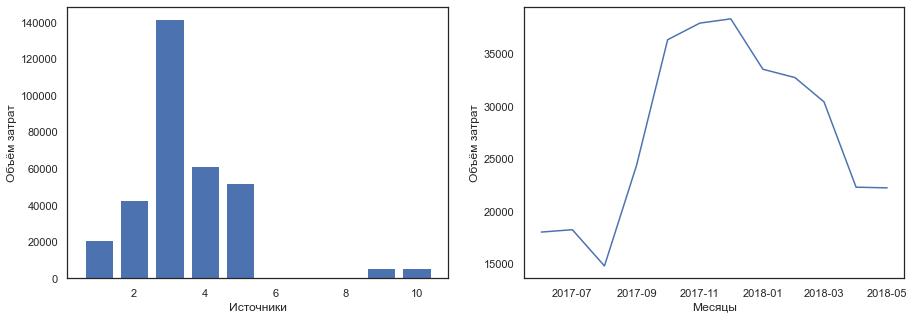

In [15]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_sum = costs['costs'].sum() # подсчитаем общую сумму затрат на маркетинг
costs_by_source = costs.groupby('source_id').agg({'costs':'sum'}) # подсчитаем сумму затрат на каждый источник
monthly_costs = costs.groupby('month').agg({'costs':'sum'}) # подсчитаем сумму затрат по месяцам

print('Общая сумма затрат на маркетинг:', costs_sum)
fig = plt.figure(figsize=(15, 5))
area = fig.add_subplot(1, 2, 1)
plt.bar(costs_by_source.index, costs_by_source['costs']) # визуализируем распределение затрат по источникам
plt.xlabel('Источники')
plt.ylabel('Объём затрат')
area = fig.add_subplot(1, 2, 2)
plt.plot(monthly_costs.index, monthly_costs['costs']) # визуализируем распределение затрат по месяцам
plt.xlabel('Месяцы')
plt.ylabel('Объём затрат')
plt.show()

In [16]:
# подсчитаем, как окупаются затраты на привлечение покупателей по когортам
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers'] # подсчитаем сумму затрат на привлечение одного покупателя
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(index='first_order_month', columns='age', values='romi', aggfunc='mean')
output.cumsum(axis=1).round(2).fillna('')

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.7,0.74,0.77,0.78,,
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.3,1.38,1.4,1.42,,,
2017-10-01,0.60,0.66,0.68,0.7,0.72,0.74,0.75,0.76,,,,
2017-11-01,0.55,0.6,0.62,0.65,0.67,0.68,0.69,,,,,
2017-12-01,0.54,0.57,0.68,0.8,0.84,0.87,,,,,,
2018-01-01,0.42,0.45,0.48,0.49,0.5,,,,,,,
2018-02-01,0.46,0.49,0.5,0.51,,,,,,,,


In [17]:
# подсчитаем средние показатели ROMI по месяцам
output.cumsum(axis=1).mean(axis=0)

age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

In [18]:
# проассоциируем каждого пользователя с источником, из которого он впервые пришел на сайт
first_date = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_date.columns = ['uid', 'first_date']
visits_first_date = pd.merge(visits, first_date, on='uid')
visits_first_date = visits_first_date.loc[:, ['source_id', 'uid', 'first_date']].sort_values(by='first_date')
visits_first_date = visits_first_date.drop_duplicates('uid')
visits_first_date.head()

,source_id,uid,first_date
333308,5,13890188992670018146,2017-06-01 00:01:00
305861,3,16152015161748786004,2017-06-01 00:02:00
296541,3,16706502037388497502,2017-06-01 00:02:00
290151,3,8842918131297115663,2017-06-01 00:04:00
50174,1,10329302124590727494,2017-06-01 00:09:00


In [19]:
# подсчитаем соотношение маркетинговых затрат на каждый источник к количеству покупок, сделанных покупателями из каждого источника
orders_with_source = pd.merge(orders, visits_first_date, on='uid', how='left')
orders_by_source = orders_with_source.groupby('source_id').agg({'uid':'count'}).reset_index()
orders_by_source.columns = ['source_id', 'number_of_purchases']
costs_by_source = costs_by_source.reset_index()
orders_by_source_costs = pd.merge(orders_by_source, costs_by_source, on='source_id', how='outer')
orders_by_source_costs['ratio'] = orders_by_source_costs['costs'] / orders_by_source_costs['number_of_purchases']
orders_by_source_costs.sort_values(by='ratio')

,source_id,number_of_purchases,costs,ratio
6,9,1964,5517.49,2.809313
0,1,6575,20833.27,3.168558
7,10,1421,5822.49,4.097460
3,4,12319,61073.60,4.957675
1,2,8267,42806.04,5.177941
4,5,8876,51757.10,5.831129
2,3,10992,141321.63,12.856771
5,7,1,NaN,NaN


In [20]:
revenue_by_source = orders_with_source.groupby('source_id').agg({'revenue':'sum'}).reset_index()
revenue_by_source.columns = ['source_id', 'total_revenue']
revenue_by_source_costs = pd.merge(revenue_by_source, costs_by_source, on='source_id', how='outer')
revenue_by_source_costs['ROI'] =  revenue_by_source_costs['total_revenue'] / revenue_by_source_costs['costs']
revenue_by_source_costs.sort_values(by='ROI', ascending=False)

,source_id,total_revenue,costs,ROI
0,1,38332.55,20833.27,1.839968
1,2,69618.85,42806.04,1.626379
6,9,6407.26,5517.49,1.161264
3,4,51502.85,61073.60,0.843292
4,5,38605.72,51757.10,0.745902
7,10,3983.10,5822.49,0.684089
2,3,43605.65,141321.63,0.308556
5,7,1.22,NaN,NaN


#### Выводы по шагу 2.3.

- Как видно из показателя ROMI, маркетинговые затраты на когорту отбиваются не ранее 8-10 месяца жизни кажой когорты
- Больше всего денег было потрачено на привлечение покупателей из источника № 3, а также, в меньшей степени, №№ 2, 4 и 5. 
- При этом оказалось, что источник № 3  наименее эффективен: каждая покупка, привлеченная из этого источника, стоила в несколько раз дороже, чем покупка, привлеченная из любого другого источника, а ROI составил лишь 0,3. Наибольший ROI - у источника № 1.

### Общие выводы по проекту.

В ходе проекта мы изучили, как менялась посещаемость сайта в течение исследуемого периода (метрики DAU, MAU, WAU), были построены тепловые карты Churn Rate и Retention Rate, были проанализированы траты пользователей по когортам (метрика LTV), а также объемы и сроки окупаемости маркетинговых затрат (метрики CAC и ROMI).

С учетом резко падающего во второй месяц числа покупок и их стоимости маркетологам стоит продумать механизмы повторного привлечения покупателей - например, внедрение карт лояльности. 

В настоящий момент доля визитов на сайт с десктопов заметно превышает долю визитов с мобильных устройств. С учетом того, что сейчас мобильный трафик в рунете превышает десктопный (https://radar.yandex.ru/device_categories?period=all), стоит продумать варианты привлечения пользователей смартфонов и планшетов: разработать собственное приложение, продвигать рекламу в источниках, актуальных для пользователей мобильных устройств (инстаграм и др.)

Кроме того, следует перераспределить распределение маркетинговых трат: да, пик маркетинговых трат и пик количества уникальных пользователей действительно совпадают (декабрь 2017 г.), однако выбор источников неоптимальный - больше всего денег было потрачено на источник № 3, в то время как покупатели, привлеченные из этого источника, купили слишком мало. Стоит перераспределить траты в пользу источников № 1, 2 и 9.